In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get class names
class_path = 'labels.csv'
classes = pd.read_csv(class_path)
class_names = list(classes['Name'])
print(class_names)

['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Speed limit (30km/h)', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'speed limit (80km/h)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Unknown1', 'Unknown2', 'Unknown3', 'Go right or straight', 'Go left or straight', 'Unknown4', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Unknown5', 'Fences', 'Heavy Vehicle Accidents'

In [3]:
data_dir = 'DATA'
num_images = pd.DataFrame(class_names, columns=['label'])

In [4]:
import os

In [5]:
count = []
for dir in os.listdir(data_dir):
    count.append(len(os.listdir(data_dir + '/' + dir)))
num_images['count'] = count
num_images.head()

,label,count
0,Speed limit (5km/h),118
1,Speed limit (15km/h),40
2,Speed limit (30km/h),70
3,Speed limit (40km/h),138
4,Speed limit (50km/h),96


In [6]:
num_images.label.value_counts()
num_images.sort_values('count')[:10]

,label,count
57,Unknown8,2
49,Unknown5,2
18,Speed limit (40km/h),2
27,Roundabout mandatory,4
11,Dont Go Left,4
53,Give Way,6
47,Train Crossing,8
10,Dont Go straight,8
56,Unknown7,8
43,Go right or straight,10


In [7]:
datagen = ImageDataGenerator(rescale = 1.0/255, validation_split=0.5)

In [8]:
BATCH_SIZE = 32
train_gen = datagen.flow_from_directory(data_dir, class_mode='categorical', subset='training', batch_size=BATCH_SIZE)
test_gen = datagen.flow_from_directory(data_dir, class_mode='categorical', subset='validation', batch_size=BATCH_SIZE, shuffle=False)

Found 2085 images belonging to 58 classes.
Found 2085 images belonging to 58 classes.


In [9]:
train_images = train_gen.samples
test_images = test_gen.samples

In [10]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
batchX, batchY = train_gen.next()
print('train batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
batchX, batchY = test_gen.next()
print('test batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
input_shape = batchX.shape[1:]

train batch shape=(32, 256, 256, 3), min=0.000, max=1.000
test batch shape=(32, 256, 256, 3), min=0.000, max=1.000


In [13]:
pretrained_base=Xception(include_top=False, input_shape = input_shape, pooling='avg', weights="imagenet")
pretrained_base.trainable=False
model = Sequential(
    [
    pretrained_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(len(class_names), activation='softmax')
    ]
)



83683744/83683744 [==============================] - 88s 1us/step


In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 58)                14906     
                                                                 
Total params: 21400930 (81.64 MB)
Trainable params: 539450 (2.06 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
None


In [15]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
callback= EarlyStopping(
  monitor="val_loss",
  min_delta=0.001,
  patience=5,
  restore_best_weights=True)

In [17]:
hist = model.fit_generator(steps_per_epoch=train_images/BATCH_SIZE, generator=train_gen, validation_data= test_gen,
                           validation_steps=test_images/BATCH_SIZE, epochs=10, callbacks=[callback])

C:\Users\HP\AppData\Local\Temp\ipykernel_16128\3753225361.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=train_images/BATCH_SIZE, generator=train_gen, validation_data= test_gen,


Epoch 1/10


65/65 [==============================] - 285s 4s/step - loss: 2.0250 - accuracy: 0.5285 - val_loss: 0.9314 - val_accuracy: 0.7885
Epoch 2/10
65/65 [==============================] - 256s 4s/step - loss: 0.7452 - accuracy: 0.8177 - val_loss: 0.4461 - val_accuracy: 0.9175
Epoch 3/10
65/65 [==============================] - 257s 4s/step - loss: 0.4278 - accuracy: 0.9012 - val_loss: 0.2720 - val_accuracy: 0.9453
Epoch 4/10
65/65 [==============================] - 276s 4s/step - loss: 0.2778 - accuracy: 0.9400 - val_loss: 0.1607 - val_accuracy: 0.9698
Epoch 5/10
65/65 [==============================] - 289s 4s/step - loss: 0.1715 - accuracy: 0.9683 - val_loss: 0.1070 - val_accuracy: 0.9832
Epoch 6/10
65/65 [==============================] - 278s 4s/step - loss: 0.1277 - accuracy: 0.9746 - val_loss: 0.0750 - val_accuracy: 0.9942
Epoch 7/10
65/65 [==============================] - 279s 4s/step - loss: 0.0913 - accuracy: 0.9856 - val_loss: 0.0514 - val_accuracy: 0.9981
Epoch 8/10


In [18]:
model.save('classification.h5')

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


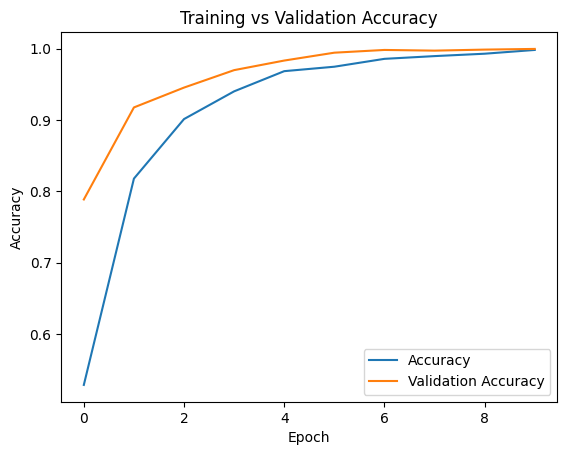

In [20]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(["Accuracy","Validation Accuracy"])

In [21]:
test_gen.reset()
raw_predictions = model.predict(test_gen)

66/66 [==============================] - 139s 2s/step


In [22]:
predictions = []
for item in raw_predictions:
    predictions.append(np.argmax(item))

In [23]:
predictions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
